In [1]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.9.2 umap==0.5.5 numpy==1.24.4 scipy==1.10.1 pandas==2.0.3 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [2]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    'data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('../write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


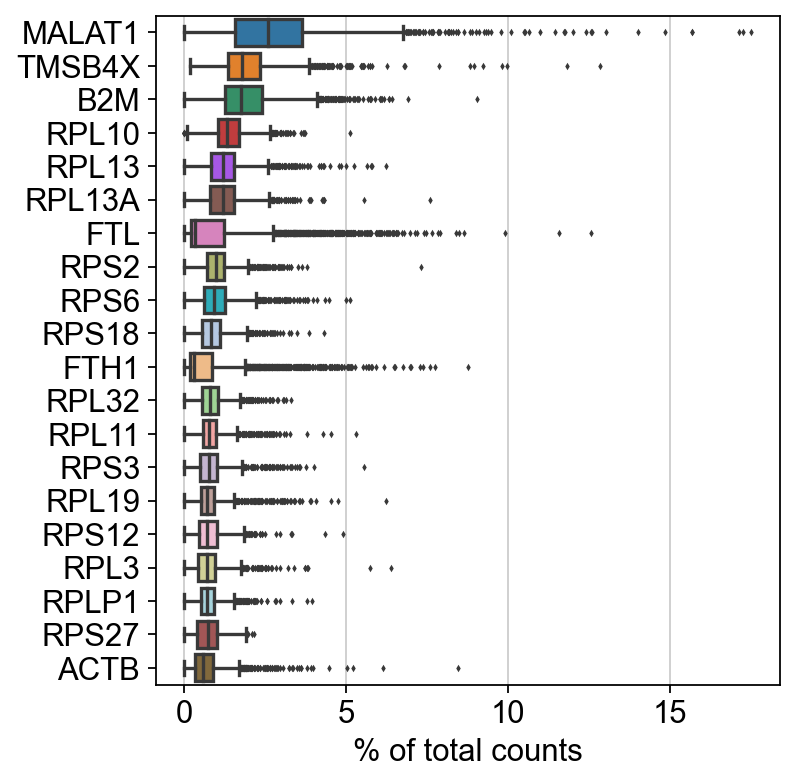

In [3]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [4]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


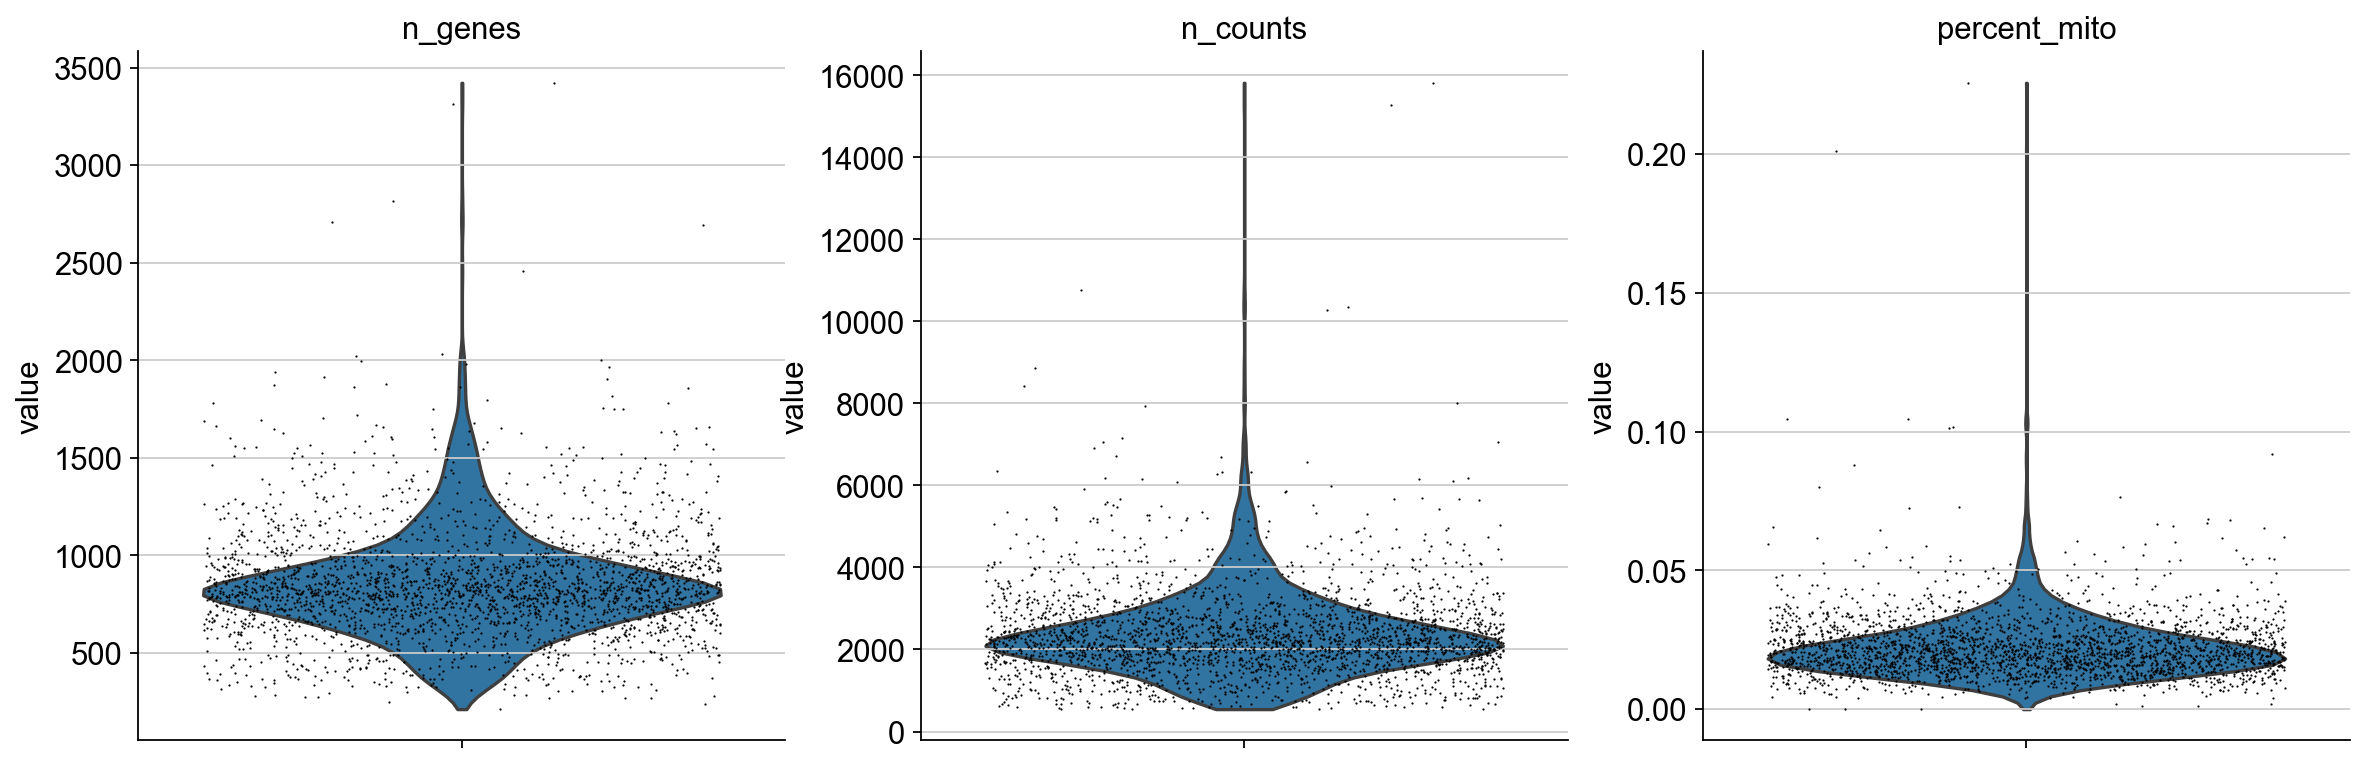

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [5]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [6]:
# scvi requires a counts layer 
adata.layers["counts"] = adata.X.copy() # preserve counts
adata.X = adata.layers["counts"].copy() # use counts for normalization and dimensionality reduction
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'
    layers: 'counts'

In [7]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)


normalizing counts per cell
    finished (0:00:00)


In [8]:
# Store the raw data
adata.raw = adata

In [9]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    subset=True,
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


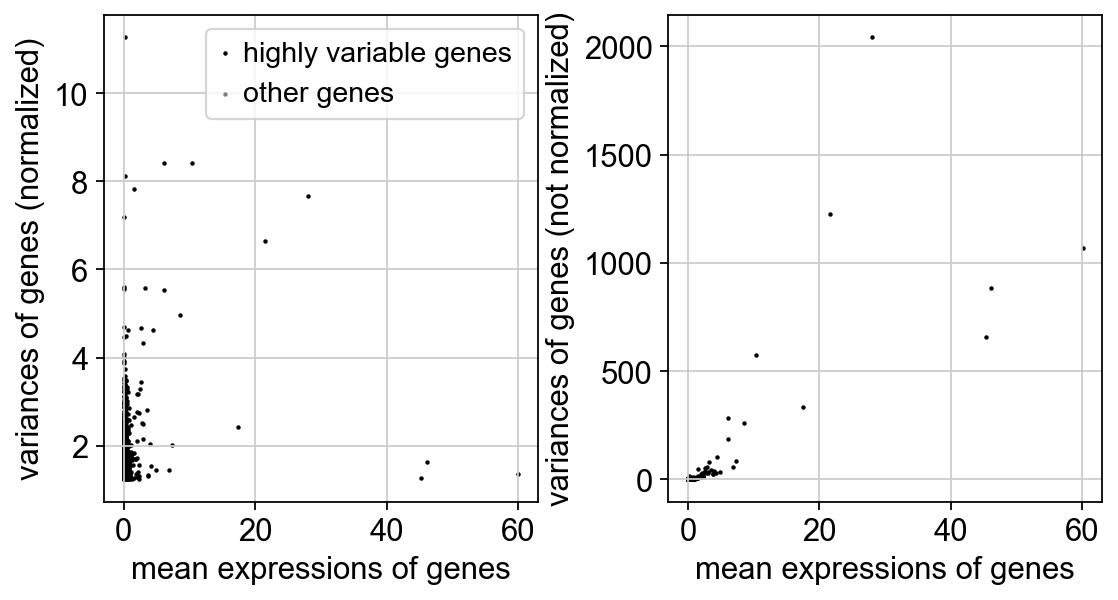

In [10]:
sc.pl.highly_variable_genes(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

## Dimension Reduction

### scVAE - scvi-tools

In [12]:
import scvi
print(scvi.__version__)

Global seed set to 0


0.20.3


In [13]:
# Integrate the data
scvi.model.SCVI.setup_anndata(adata, layer="counts")

In [14]:
# Intialize the model
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")
model = scvi.model.LinearSCVI(adata, n_latent=10)

In [15]:
# Train the model
model.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 250/250: 100%|██████████| 250/250 [01:38<00:00,  2.56it/s, loss=647, v_num=1] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [01:38<00:00,  2.54it/s, loss=647, v_num=1]


<Axes: xlabel='epoch'>

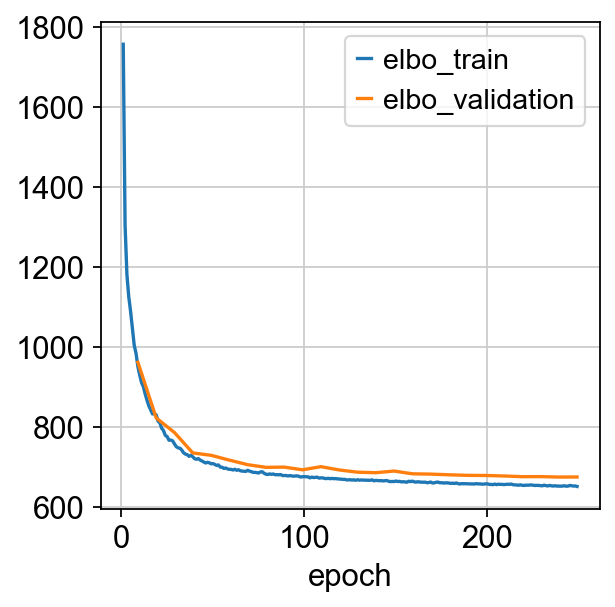

In [16]:
#Inspecting the convergence
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [17]:
# Extract the latent space representation
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

# The result is a numpy array with the reduced representation
print(Z_hat.shape)


(2638, 10)


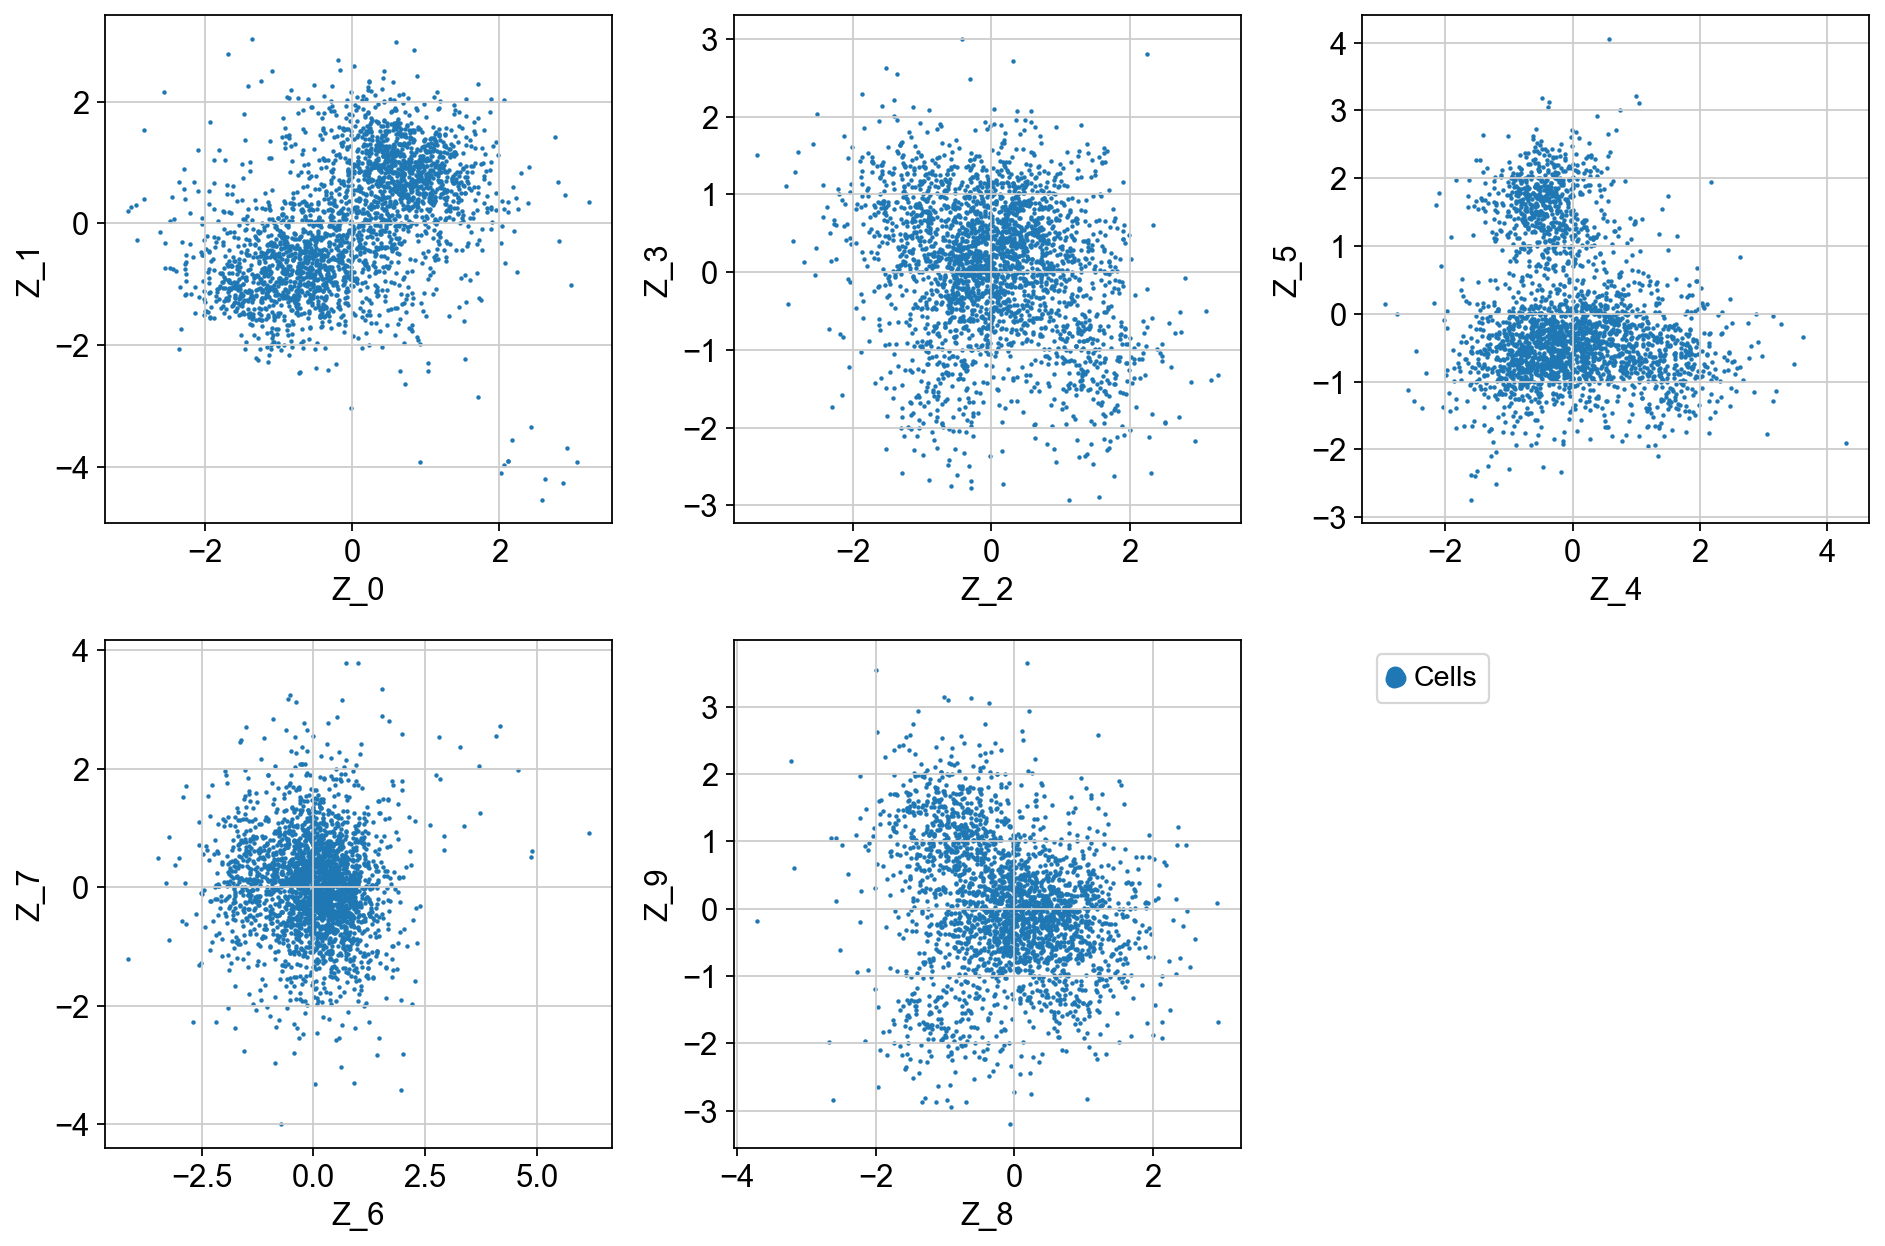

In [19]:
# Visualize the latent space
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(
        adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells"
    )

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(
    adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4
)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()


In [20]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
ISG15,-0.170075,0.369224,-0.133943,-0.175659,-0.117938,0.143468,-0.065371,0.353074,-0.079010,0.021208
CPSF3L,-0.184979,0.360423,-0.334927,0.173727,-0.124803,-0.435576,-0.188636,-0.090379,-0.126292,-0.458181
MRPL20,0.412711,0.242683,0.067820,0.001746,0.056311,0.088090,-0.262395,0.161741,-0.009040,-0.021526
ATAD3C,0.383944,0.068222,0.196039,-0.222324,-0.680699,-0.547660,0.010592,-0.700723,-0.255102,-0.123837
C1orf86,0.163012,0.023431,0.156613,0.101581,0.219519,-0.096378,0.068243,-0.267806,0.114167,0.102119


In [21]:
SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata.obsm[SCVI_LATENT_KEY] = Z_hat

In [22]:
# Write the data
adata.write("../write/pbmc3k_scvi.h5ad", compression="gzip")

In [23]:
adata

AnnData object with n_obs × n_vars = 2638 × 2000
    obs: 'n_genes', 'percent_mito', 'n_counts', '_scvi_batch', '_scvi_labels', 'Z_0', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'counts'

In [25]:
# The result is in X_scVi, which we can add back to the AnnData object
scVi_results = adata.obsm['X_scVI']

# Convert ZIFA results to DataFrame
scVi_df = pd.DataFrame(scVi_results, index=adata.obs_names, columns=[f'scVI_dim{i+1}' for i in range(10)])

# Save to CSV file
scVi_df.to_csv('../csv_files/scVi_df_results.csv')